In [1]:
cd fortran-src/

/Users/will/Dropbox/Teaching/Estelar/Tarea-03-GreyAtmos/fortran-src


In [2]:
from fg4py import fm_p, fm_planck, fm_e2, fm_flux

In [3]:
print(fm_planck.__doc__)

rslt = fm_planck(alpha,tau)

Wrapper for ``fm_planck``.

Parameters
----------
alpha : input rank-1 array('f') with bounds (f2py_alpha_d0)
tau : input rank-1 array('f') with bounds (f2py_tau_d0)

Returns
-------
rslt : rank-2 array('f') with bounds (size(alpha),size(tau))



Check that the $p(\tau)$ function works

In [4]:
fm_p([0, 1, 2, 4])

array([ 1.18920708,  0.94574159,  0.84089643,  0.73111045], dtype=float32)

Check that $B_\alpha(\tau)$ works for vector of $\alpha$ and a single $\tau$:

In [5]:
fm_planck([0.001, 1, 3, 9], 1)

array([[  1.62751633e-07],
       [  9.77885053e-02],
       [  2.58752614e-01],
       [  2.25805026e-02]], dtype=float32)

Check that $B_\alpha(\tau)$ works for a vector of $\tau$ and a single $\alpha$:

In [6]:
fm_planck(9.0, [0, 1, 2, 4, 8])

array([[ 0.00252368,  0.0225805 ,  0.0580328 ,  0.15601532,  0.40164581]], dtype=float32)

Set up python for plotting the results:

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(context='notebook', 
        style='whitegrid', 
        palette='dark',
        font_scale=1.5,
        color_codes=True,
        rc={'figure.figsize': (8,6)},
       )

In [8]:
alpha_pts = np.linspace(0.0, 12.0, 200)
taus = [0.0, 1.0, 2.0, 4.0, 8.0]
alphas = [1.0, 3.0, 9.0]
tau_pts = np.linspace(0.0, 20.0, 200)
tau_label = r'Optical depth: $\tau$'
alpha_label = r'Frequency: $\alpha = h \nu / k T_\mathrm{eff}$'
planck_label = r'Planck function: $B_\alpha[T(\tau)] / B[T_\mathrm{eff}]$'

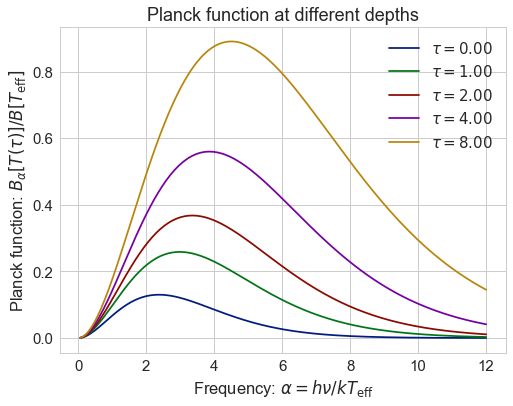

In [9]:
fig, ax = plt.subplots(1, 1)
for tau in taus:
    B = fm_planck(alpha_pts, tau)
    ax.plot(alpha_pts, B, label=r'$\tau = {:.2f}$'.format(tau))
ax.legend()
ax.set_xlabel(alpha_label)
ax.set_ylabel(planck_label)
ax.set_title('Planck function at different depths')
None

Note that `fm_planck` always returns a rank-2 array, so it doesn't behave quite like the numpy implementation. 

In [10]:
fm_planck(3.0, 0.5)

array([[ 0.19576064]], dtype=float32)

This means that we have to use the transpose when we plot against $\tau$

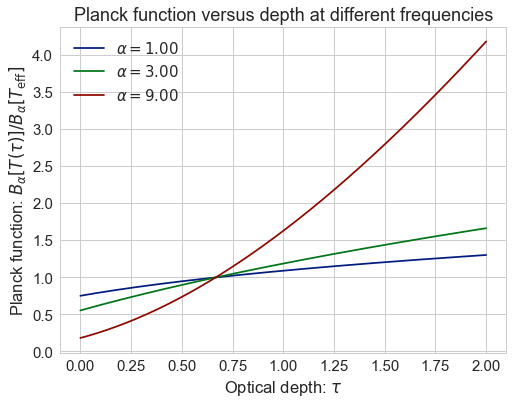

In [11]:
fig, ax = plt.subplots(1, 1)
for alpha in alphas:
    B = fm_planck(alpha, tau_pts/10)/fm_planck(alpha, 2./3.)
    ax.plot(tau_pts/10, B.T, label=r'$\alpha = {:.2f}$'.format(alpha))
ax.legend(loc='upper left')
ax.set_xlabel(tau_label)
ax.set_ylabel(planck_label.replace('B[', r'B_\alpha['))
ax.set_title('Planck function versus depth at different frequencies')
None

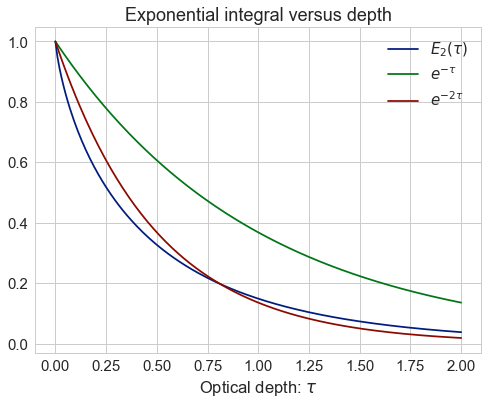

In [12]:
fig, ax = plt.subplots(1, 1)
t = 0.00001 + tau_pts/10
e = fm_e2(t)
ax.plot(t, e, label=r'$E_2(\tau)$')
ax.plot(t, np.exp(-t), label=r'$e^{-\tau}$')
ax.plot(t, np.exp(-t/0.5), label=r'$e^{-2\tau}$')
ax.legend(loc='upper right')
ax.set_xlabel(tau_label)
ax.set_ylabel('')
ax.set_title('Exponential integral versus depth')
None

Now, try out the flux integral.  This is just repeating all the plots in the python version, but with the `fm_*` fortran routines, instead of the python ones.

In [13]:
flux_label = r'Radiative flux: $H_\alpha(\tau) / H$'

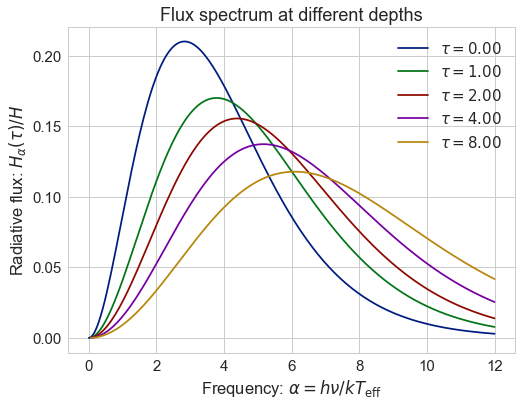

In [14]:
fig, ax = plt.subplots(1, 1)
Hlist = []
for tau in taus:
    H = fm_flux(alpha_pts, tau)
    ax.plot(alpha_pts, H, label=r'$\tau = {:.2f}$'.format(tau))
    Hlist.append(H)
ax.legend()
ax.set_xlabel(alpha_label)
ax.set_ylabel(flux_label)
ax.set_title('Flux spectrum at different depths')
None

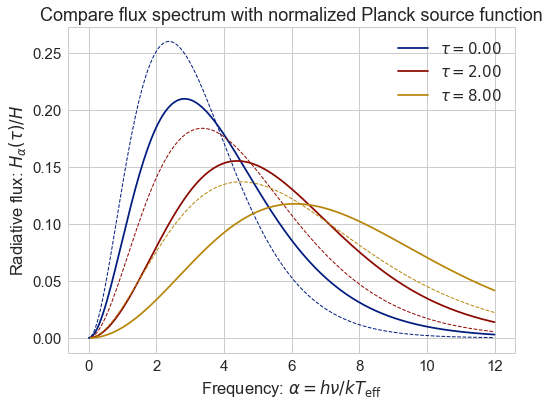

In [16]:
fig, ax = plt.subplots(1, 1)
colors = 'bry'
for tau, H, color in zip(taus[::2], Hlist[::2], colors):
    ax.plot(alpha_pts, H, c=color, 
            label=r'$\tau = {:.2f}$'.format(tau))
    B = fm_p(tau)**4 * fm_planck(alpha_pts, tau)
    ax.plot(alpha_pts, B, lw=1, ls='--', c=color, label=None)
ax.legend()
ax.set_xlabel(alpha_label)
ax.set_ylabel(flux_label)
ax.set_title('Compare flux spectrum with normalized Planck source function')
None

As far as I can see, these curves are identical to the pure-python ones.  The only thing remaining to do is the schwarschild integral for the mean intensity.

### How to use fortran cells in a jupyter notebook

Test of fortran-magic, see [this blog post](http://arogozhnikov.github.io/2015/11/29/using-fortran-from-python.html)

In [18]:
%load_ext fortranmagic

The fortranmagic extension is already loaded. To reload it, use:
  %reload_ext fortranmagic


We test with a simple function, implemented as a subroutine with an `intent(out)` argument.  We also use a module for furher communication with the function.

In [2]:
%%fortran --opt='-O3'
module myparams
    real :: constant = 1.0
end module

subroutine add_constant(x, rslt)
    use myparams
    real, intent(in) :: x(:)
    real, intent(out) :: rslt(size(x))
    rslt = x + constant
end subroutine


When we evaluate the above cell, it compiles the fortran and exports `add_constant` as a function that can be called from python. 

In [5]:
import numpy as np

In [6]:
add_constant([1.0, 2.0, 3.0])


array([ 2.,  3.,  4.], dtype=float32)

We can also access the variables in the `myparams` module.

In [7]:
myparams.constant = -2.0
add_constant([1.0, 2.0, 3.0])

array([ 2.,  3.,  4.], dtype=float32)

Unfortunately, there does not seem to be an easy way, within a `%%fortran` cell, to `use` a module that was defined in another cell.  So we need to put everything inside one cell.  (We can access the modules within python cells however). 

In [ ]:
%%fortran --opt='-O3'
module myparams
    real :: constant = 1.0
end module

subroutine raise_to_power(x, rslt)
    use myparams
    real, intent(in) :: x(:)
    real, intent(out) :: rslt(size(x))
    rslt = x**constant
end subroutine

In [8]:
myparams.constant = -1.0
raise_to_power([1.0, 2.0, 3.0])

array([ 1.        ,  0.5       ,  0.33333334], dtype=float32)

Trying out `elemental` functions, which can simplify the whole-array operations on the fortran side, since you just write one function of scalar arguments, which can then be applied to arrays of any shape.  But with the proviso that all the arguments *plus* the result must all be the same shape. 

In [42]:
%%fortran --opt='-O3' -v
module myparams
  real :: constant = 1.0
contains
  elemental function raise_product_to_power(x, y) result(rslt)
    real, intent(in) :: x, y
    real :: rslt
    rslt = (x*y)**constant
  end function
end module myparams

subroutine fm_raise(x, y, rslt)
  use myparams, only: raise_product_to_power
  real, intent(in) :: x(:), y(:)
  real, intent(out) :: rslt(size(x), size(y))
  real :: xx(size(x), size(y)), yy(size(x), size(y))
  xx = spread(x, dim=2, ncopies=size(y))
  yy = spread(y, dim=1, ncopies=size(x))
  rslt = raise_product_to_power(xx, yy)
end subroutine fm_raise


Ok. The following fortran objects are ready to use: fm_raise, myparams


We want to apply this to a function of two vector arguments, where the vectors are over incommensurate dimensions (e.g., frequency and depth), so it is a kind of outer product: like $x \times y^\mathrm{\tiny T}$.  Fortran doesn't do any sort of broadcasting of degenerate array dimensions, so we do this explicitly with the fortran intrinsic `spread` function.

In [54]:
fm_raise([1, 2, 3], [10, 100])

array([[  10.,  100.],
       [  20.,  200.],
       [  30.,  300.]], dtype=float32)

So, if we send in two vectors, we get out a 2d array. 

In [55]:
fm_raise([1, 2, 3], 99)

array([[  99.],
       [ 198.],
       [ 297.]], dtype=float32)

And we can also make the second argument a scalar, in which case we get a column vector result. 

In [56]:
fm_raise(2, [10, 100])

array([[  20.,  200.]], dtype=float32)

Or make the first argument a scalar, to give a row vector result.  But in both cases, they are really still 2D results, but with one dim of size 1.

In [53]:
np.array([[1, 2]]) * np.array([[2, 3, 4]]).T

array([[2, 4],
       [3, 6],
       [4, 8]])

### Earlier version of grey atmosphere routines using fortan magic

I had a *lot* of trouble with paths to shared libraries (they were found at compile time, but then couldn't be found at run time).  So, I eventually decided to just use the normal f2py machinery instead.  But I leave this here for historical reference.

In [1]:
%load_ext fortranmagic

/Users/will/anaconda/lib/python3.6/site-packages/fortranmagic.py:147: UserWarning: get_ipython_cache_dir has moved to the IPython.paths module since IPython 4.0.
  self._lib_dir = os.path.join(get_ipython_cache_dir(), 'fortran')


First, we do a direct translation of some functions from the python version.

General strategy: 

1. Define wrapper functions `fm_*` (where fm stands for fortran magic) that conform to the odd way that f2py likes to have things defined.  That is, subroutines with `intent(out)` argument for the return value, instead of a function. 
2. These subroutines include the module `fgrey`, in which we are free to write more idiomatic fortran (although when I tried to use `public` and `private` it didn't work - not sure why). 

In [10]:
%fortran_config --defaults


Deleted custom config. Back to default arguments for %%fortran


In [74]:
%%fortran -vvv --opt='-O3' --extra './libfgrey.so'  --f90flags='-Wl,-rpath,.' --f77flags='-Wl,-rpath,.'

subroutine fm_e2(t, rslt)
  use fspecial, only: e2
  real, intent(in) :: t(:)
  real, intent(out) :: rslt(size(t))
  integer :: i
  rslt = (/(e2(t(i)), i = 1, size(t))/)
end subroutine

subroutine fm_p(tau, rslt)
    use planck_grey, only: p
    real, intent(in) :: tau(:)
    real, intent(out) :: rslt(size(tau))
    rslt = p(tau)
end subroutine

subroutine fm_planck(alpha, tau, rslt)
    use planck_grey, only: planck
    real, intent(in) :: alpha(:), tau(:)
    real, intent(out) :: rslt(size(alpha), size(tau))
    real :: aalpha(size(alpha), size(tau)), ttau(size(alpha), size(tau))
    aalpha = spread(alpha, dim=2, ncopies=size(tau))
    ttau = spread(tau, dim=1, ncopies=size(alpha))
    rslt = planck(aalpha, ttau)
end subroutine

Running...
   /Users/will/anaconda/bin/python -m numpy.f2py --fcompiler=gnu95 --f90flags='-Wl,-rpath,.' --f77flags='-Wl,-rpath,.' --opt='-O3' ./libfgrey.so -m _fortran_magic_de8a64c7025eb58b0899ce8f4f1eee87 -c /Users/will/.ipython/fortran/_fortran_magic_de8a64c7025eb58b0899ce8f4f1eee87.f90
running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "_fortran_magic_de8a64c7025eb58b0899ce8f4f1eee87" sources
f2py options: []
f2py:> /var/folders/rm/hnrktx9s22g8sbms445k0z000000gn/T/tmpnqnhn2p6/src.macosx-10.7-x86_64-3.6/_fortran_magic_de8a64c7025eb58b0899ce8f4f1eee87module.c
creating /var/folders/rm/hnrktx9s22g8sbms445k0z000000gn/T/tmpnqnhn2p6/src.macosx-10.7-x86_64-3.6
Reading fortran codes...
	Reading file '/Users/will/.ipython/fortran/_fortran_magic_de8a64c7025eb58b0899ce8f4f1eee87.f90

ImportError: dlopen(/Users/will/.ipython/fortran/_fortran_magic_de8a64c7025eb58b0899ce8f4f1eee87.cpython-36m-darwin.so, 2): Library not loaded: libfgrey.so
  Referenced from: /Users/will/.ipython/fortran/_fortran_magic_de8a64c7025eb58b0899ce8f4f1eee87.cpython-36m-darwin.so
  Reason: image not found